In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold

In [2]:
# Set the random state for reproducing result
np.random.seed(124)

""" Helper Function """

# Define the polynomial basis function
def basis_function(x, k):
    return np.array([x**i for i in range(k)]).T

# Define the sin basis function
def sin_basis_function(x, k):
    return np.array([np.sin(i * np.pi * x) for i in range(1, k + 1)]).T

# Calculate the weights for linear regression
def calculate_weight(phi, y):
    return np.linalg.inv(phi.T @ phi) @ phi.T @ y

# Compute the mean squared error given two inputs
def calculate_mse(y, y_pred):
    return np.mean((y - y_pred) ** 2)
 
# Define the target function with added Gaussian noise
def g_sigma(x, sigma):
    epsilon = np.random.normal(0, sigma)
    return np.sin(2 * np.pi * x)**2 + epsilon

# Generate random samples from the target function
def get_samples(nums, sigma):
    X = np.random.uniform(0, 1, nums)
    y = [g_sigma(x, sigma) for x in X]

    return X, y

# Define the Gaussian kernel function
def gaussian_kernel(x_i, x_j, sigma):
    return np.exp(-np.linalg.norm(x_i - x_j)**2 / (2 * sigma**2))

# Compute the kernel matrix for a given dataset and sigma
def compute_kernel(X, sigma):
    num_of_data = len(X)
    K = np.zeros([num_of_data, num_of_data])
    for i in range(num_of_data):
        for j in range(num_of_data):
            K[i][j] = gaussian_kernel(X[i], X[j], sigma)
    return K

# Train and validate the model using 5-folds cross-validation
def train_and_validate(X_train, y_train, gamma, sigma, kf):
    mses = []
    
    for train_index, validation_index in kf.split(X_train):
        
        # Get the training set and validation set using k-fold
        X_train_k_fold, y_train_k_fold = X_train.iloc[train_index].values, y_train.iloc[train_index].values
        X_validation_k_fold, y_validation_k_fold = X_train.iloc[validation_index].values, y_train.iloc[validation_index].values

        # Compute the Kernel and alpha using the training set
        K = compute_kernel(X_train_k_fold, sigma)
        alpha = np.linalg.inv(K + gamma * len(K) * np.identity(len(K))) @ y_train_k_fold

        # Predict the validation set
        y_preds = [sum(alpha[i] * gaussian_kernel(X_train_k_fold[i], x_val, sigma) for i in range(len(X_train_k_fold))) for x_val in X_validation_k_fold]
        
        # Record the MSE
        mses.append(calculate_mse(y_validation_k_fold, y_preds))
    
    return np.mean(mses)

# Find the best hyperparameters using cross-validation
def find_best_parameters(X_train, y_train, gammas, sigmas, kf):
    best_gamma = 0
    best_sigma = 0
    
    # Record the minimum mse and the MSE for all combinations of gamma and sigma
    min_mse = float('inf')
    mean_square_errors = np.zeros([len(gammas), len(sigmas)])

    for i, g in enumerate(gammas):
        for j, s in enumerate(sigmas):
            # Calculate the mse for specific gamma and sigma
            mse = train_and_validate(X_train, y_train, g, s, kf)
            mean_square_errors[i][j] = mse
            
            # If mse lower than current best, update it
            if mse < min_mse:
                min_mse = mse
                best_gamma = g
                best_sigma = s

    return best_gamma, best_sigma, min_mse, mean_square_errors

# Convert a number to its power of two representation for printing
def to_power_of_two(decimal_number):
    exponent = int(np.log2(decimal_number))
    return f"$2^{{{exponent}}}$"

# Define naive regression
def naive_regression(X_train, X_test, y_train, y_test, mses, idx):
    ones_train = np.ones((len(X_train), 1))
    ones_test = np.ones((len(X_test), 1))
    
    weights = calculate_weight(ones_train, y_train)
    
    y_pred_train = ones_train @ weights
    y_pred_test = ones_test @ weights

    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)
    
    # Record the training and test error of that iteration
    mses[idx][0] = mse_train
    mses[idx][1] = mse_test
    return
    
# Define linear regression using a single attribute
def single_attribute_regression(X_train, X_test, y_train, y_test, mses, idx):
    train_attributes = [np.array(X_train[attribute]) for attribute in X_train]
    test_attributes = [np.array(X_test[attribute]) for attribute in X_test]

    for j in range(len(train_attributes)):
        # Add column of ones to the X represents bias
        X_train_augmented = np.vstack((train_attributes[j], np.ones_like(train_attributes[j]))).T
        X_test_agumented = np.vstack((test_attributes[j], np.ones_like(test_attributes[j]))).T
        weights = calculate_weight(X_train_augmented, y_train)

        y_pred_train = X_train_augmented @ weights
        y_pred_test = X_test_agumented @ weights

        mse_train = calculate_mse(y_train, y_pred_train)
        mse_test = calculate_mse(y_test, y_pred_test)

        mses[idx][j][0] = mse_train
        mses[idx][j][1] = mse_test
    return

# Define linear regression using all attributes
def all_attribute_regression(X_train, X_test, y_train, y_test, mses, idx):
    # Add column of ones to the X represents bias
    X_train_augmented = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
    X_test_agumented = np.hstack((X_test, np.ones((X_test.shape[0], 1))))

    weights = calculate_weight(X_train_augmented, y_train)

    y_pred_train = X_train_augmented @ weights
    y_pred_test = X_test_agumented @ weights

    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)

    mses[idx][0] = mse_train
    mses[idx][1] = mse_test
    return
    
# Define kernel ridge regression
def kernel_ridge_regression(X_train, X_test, y_train, y_test, mses, idx):
    # Using K-fold CV to find the best gamma and sigma
    best_gamma, best_sigma, min_mse, mean_square_errors = find_best_parameters(X_train, y_train, gamma, sigma, kf)
    
    X_train_val, y_train_val = X_train.values, y_train.values
    X_test_val, y_test_val = X_test.values, y_test.values

    K = compute_kernel(X_train_val, best_sigma)
    alpha = np.linalg.inv(K + best_gamma * len(K) * np.identity(len(K))) @ y_train_val

    y_pred_train = [sum(alpha[i] * gaussian_kernel(X_train_val[i], x_train, best_sigma) for i in range(len(X_train_val))) for x_train in X_train_val]
    y_pred_test = [sum(alpha[i] * gaussian_kernel(X_train_val[i], x_test, best_sigma) for i in range(len(X_train_val))) for x_test in X_test_val]
    
    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)
    
    mses[idx][0] = mse_train
    mses[idx][1] = mse_test
    return

# Display the mean and standard deviation of the MSEs
def show_mean_and_std(mses_naive, mses_single_attribute, mses_all_attribute, mses_krr):
    
    # Convert all list to np.array
    mses_naive = np.array(mses_naive)
    mses_single_attribute = np.array(mses_single_attribute)
    mses_all_attribute = np.array(mses_all_attribute)
    mses_krr = np.array(mses_krr)

    print("---------------- Naive Regression ----------------")
    print(f"Training Error --- {mses_naive.mean(axis=0)[0]:.3f} ± {mses_naive.std(axis=0)[0]:.3f}")
    print(f"Test Error     --- {mses_naive.mean(axis=0)[1]:.3f} ± {mses_naive.std(axis=0)[1]:.3f}")

    for i in range(12):
        print(f"\n------------- Linear Regression (attribute {i+1}) -------------")
        print(f"Training Error --- {mses_single_attribute.mean(axis=0)[i][0]:.3f} ± {mses_single_attribute.std(axis=0)[i][0]:.3f}")
        print(f"Test Error     --- {mses_single_attribute.mean(axis=0)[i][1]:.3f} ± {mses_single_attribute.std(axis=0)[i][1]:.3f}")

    print("\n---------------- Linear Regression (all attribute) ----------------")
    print(f"Training Error --- {mses_all_attribute.mean(axis=0)[0]:.3f} ± {mses_all_attribute.std(axis=0)[0]:.3f}")
    print(f"Test Error     --- {mses_all_attribute.mean(axis=0)[1]:.3f} ± {mses_all_attribute.std(axis=0)[1]:.3f}")

    print("\n---------------- Kernel Ridge Regression ----------------")
    print(f"Training Error --- {mses_krr.mean(axis=0)[0]:.3f} ± {mses_krr.std(axis=0)[0]:.3f}")
    print(f"Test Error     --- {mses_krr.mean(axis=0)[1]:.3f} ± {mses_krr.std(axis=0)[1]:.3f}")

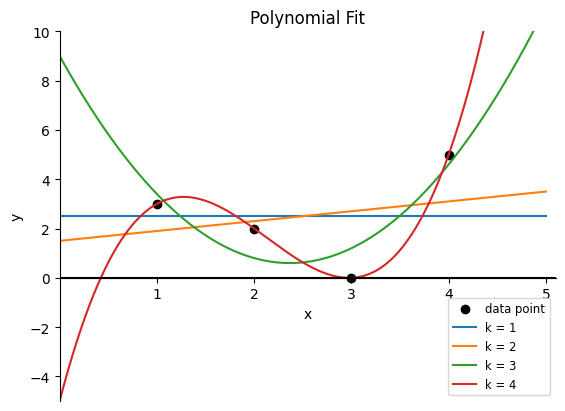

In [3]:
""" 1.1 Q1(a) """

X = np.array([1, 2, 3, 4])
y = np.array([3, 2, 0, 5])

weights = []

for k in range(1, 5):
    phi = basis_function(X, k)
    weight = calculate_weight(phi, y)
    weights.append(weight)

plt.scatter(X, y, label="data point", c='black')

x_range = np.linspace(0, 5, 1000)

for k, w in enumerate(weights, 1):
    y_predict = basis_function(x_range, k) @ w
    plt.plot(x_range, y_predict, label=f'k = {k}')
    
# Hide the right, top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move x-axis ticks to y=0
ax.spines['bottom'].set_position(('data', 0))

plt.legend(fontsize='small')
plt.xlim(0, 5.1)
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(-5, 10)
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.title("Polynomial Fit")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("q1_a.png", dpi=200)
plt.show()

In [4]:
""" 1.1 Q1(b) """
for i in range(4):
    print(f"k={i+1}, weigth: {weights[i]}")

k=1, weigth: [2.5]
k=2, weigth: [1.5 0.4]
k=3, weigth: [ 9.  -7.1  1.5]
k=4, weigth: [-5.         15.16666667 -8.5         1.33333333]


For k = 1, 2, 3,

 \( k = 1 \)  $$ y = 2.5 $$
 \( k = 2 \)  $$ y = 1.5 + 0.4x $$
 \( k = 3 \)  $$ y = 9 - 7.1x + 1.5x^2 $$


In [5]:
""" 1.1 Q1(c) """

for k, w in enumerate(weights, 1):
    y_pred = basis_function(X, k) @ w
    MSE = calculate_mse(y, y_pred)
    print(f"MSE of k = {k}:", MSE)

MSE of k = 1: 3.25
MSE of k = 2: 3.0500000000000003
MSE of k = 3: 0.7999999999999996
MSE of k = 4: 2.0886576313089008e-23


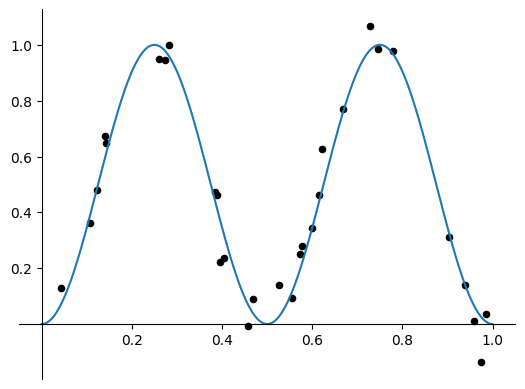

In [6]:
""" 1.1 Q2(a).i """

X_train, y_train = get_samples(30, 0.07)
plt.scatter(X_train, y_train, s=20, label="training data point", c='black')

x_range = np.linspace(0, 1, 500)
y_true = g_sigma(x_range, 0)

plt.plot(x_range, y_true)

# Hide the right, top, and bottom spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move axis ticks to x=0 and y=0
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))


plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1])

plt.savefig("q2_a1.png", dpi=200)
plt.show()

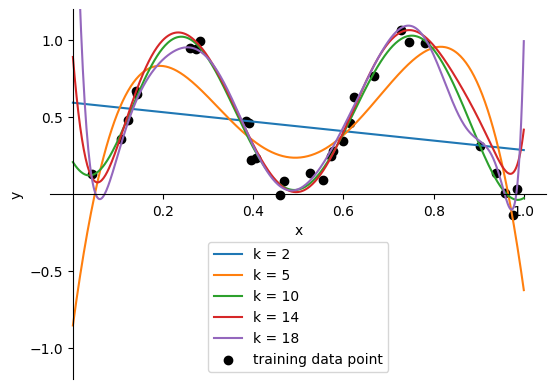

In [7]:
""" 1.1 Q2(a).ii """

weights = []
k_list = [2, 5, 10, 14, 18]
x_range = np.linspace(0, 1, 500)

for k in k_list:
    phi = basis_function(X_train, k)
    weight = calculate_weight(phi, y_train)
    y_pred = basis_function(x_range, k) @ weight
    plt.plot(x_range, y_pred, label=f'k = {k}')

# Hide the right, top, and bottom spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Move axis ticks to x=0 and y=0
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
    
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([-1, -0.5, 0.5, 1])
    
plt.scatter(X_train, y_train, label="training data point", c='black')
plt.legend()
plt.ylim(-1.2, 1.2)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('q2_a2.png', dpi=200)
plt.show()

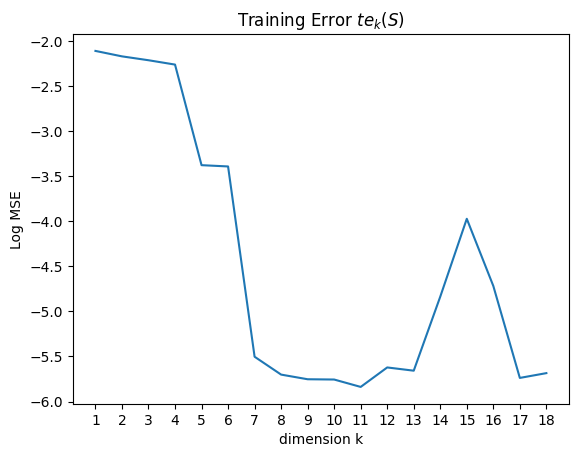

In [8]:
""" 1.1 Q2(b) """

k_list = np.arange(1, 19)
train_errors = []
weights = []

for k in k_list:
    phi = basis_function(X_train, k)
    weight = calculate_weight(phi, y_train)
    weights.append(weight)
    y_pred = basis_function(X_train, k) @ weight
    mse = calculate_mse(y_train, y_pred)
    train_errors.append(mse)
    
plt.plot(k_list, np.log(train_errors))
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Training Error $te_k(S)$")
plt.savefig("q2_b.png", dpi=200)
plt.show()

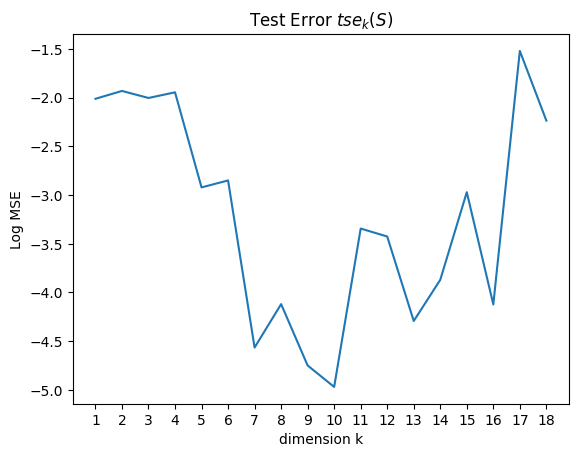

In [9]:
""" 1.1 Q2(c) """
X_test, y_test = get_samples(1000, 0.07)

test_errors = []
for k in k_list:
    y_pred = basis_function(X_test, k) @ weights[k-1]
    mse = calculate_mse(y_test, y_pred)
    
    test_errors.append(mse)
    
plt.plot(k_list, np.log(test_errors))
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Test Error $tse_k(S)$")
plt.savefig("q2_c.png", dpi=200)
plt.show()

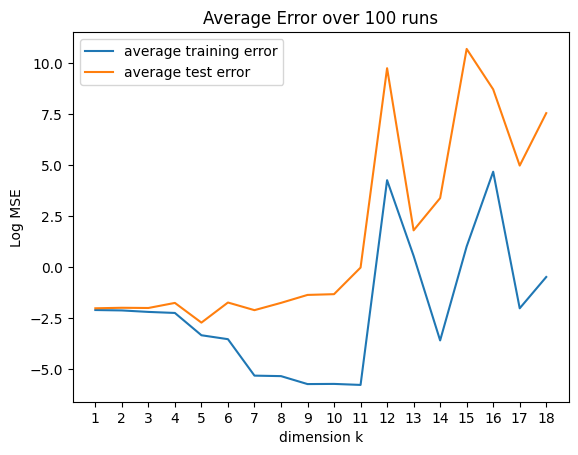

In [10]:
""" 1.1 Q2(d) """
training_errors_avg = []
testing_errors_avg = []

for k in k_list:
    # record the errors of 100 iterations for each k
    train_errors = []
    test_errors = []
    for _ in range(100):
        # Generate the training and testing data for each iteration
        X_train, y_train = get_samples(30, 0.07)
        X_test, y_test = get_samples(1000, 0.07)
        
        # Using the training data to calculate the optimal weight
        phi = basis_function(X_train, k)
        weight = calculate_weight(phi, y_train)
        
        # Record the train error and test error of each iteration 
        y_pred_train = basis_function(X_train, k) @ weight
        mse_train = calculate_mse(y_train, y_pred_train)
        
        y_pred_test = basis_function(X_test, k) @ weight
        mse_test = calculate_mse(y_test, y_pred_test)
        
        train_errors.append(mse_train)
        test_errors.append(mse_test)
        
    training_errors_avg.append(np.mean(train_errors))
    testing_errors_avg.append(np.mean(test_errors))
    
plt.plot(k_list, np.log(training_errors_avg), label="average training error")
plt.plot(k_list, np.log(testing_errors_avg), label="average test error")
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Average Error over 100 runs")
plt.legend()
plt.savefig("q2_d.png", dpi=200)
plt.show()

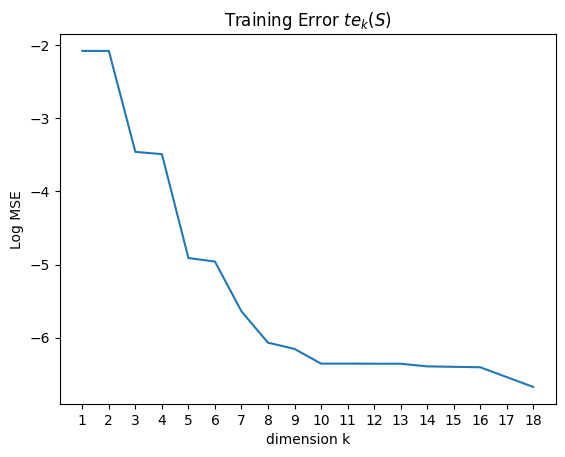

In [11]:
""" 1.1 Q3 Experiment b """
train_errors = []
weights = []
X_train, y_train = get_samples(30, 0.07)

for k in k_list:
    phi = sin_basis_function(X_train, k)
    weight = calculate_weight(phi, y_train)
    weights.append(weight)
    
    y_predict = sin_basis_function(X_train, k) @ weight
    mse = calculate_mse(y_train, y_predict)
    train_errors.append(mse)
    
plt.plot(k_list, np.log(train_errors))
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Training Error $te_k(S)$")
plt.savefig("q3_b.png", dpi=200)
plt.show()

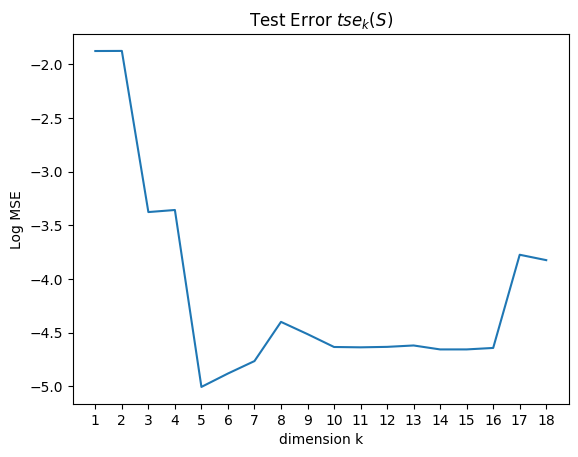

In [12]:
""" 1.1 Q3 Experiment c """
X_test, y_test = get_samples(1000, 0.07)
test_errors = []

for k in k_list:
    y_predict = sin_basis_function(X_test, k) @ weights[k-1]
    mse = calculate_mse(y_test, y_predict)
    test_errors.append(mse)
    
plt.plot(k_list, np.log(test_errors))
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Test Error $tse_k(S)$")
plt.savefig("q3_c.png", dpi=200)
plt.show()

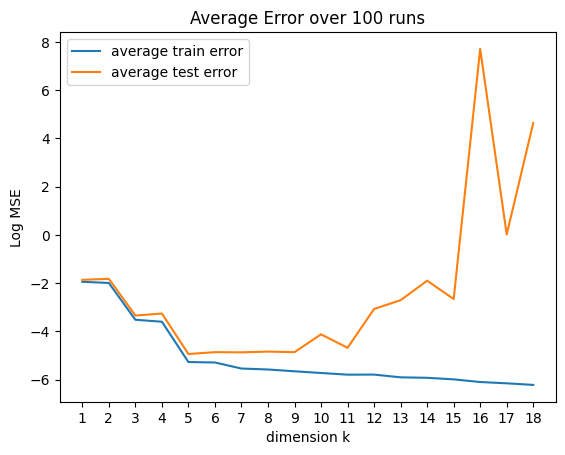

In [13]:
""" 1.1 Q3 Experiment d """
training_errors_avg = []
testing_errors_avg = []

for k in k_list:
    # record the errors of 100 iterations for each k
    train_errors = []
    test_errors = []
    for _ in range(100):
        # Generate the training and testing data for each iteration
        X_train, y_train = get_samples(30, 0.07)
        X_test, y_test = get_samples(1000, 0.07)
        
        # Using the training data to calculate the optimal weight
        phi = sin_basis_function(X_train, k)
        weight = calculate_weight(phi, y_train)
        
        # Record the train error and test error of each iteration 
        y_predict_train = sin_basis_function(X_train, k) @ weight
        mse_train = calculate_mse(y_train, y_predict_train)
        
        y_predict_test = sin_basis_function(X_test, k) @ weight
        mse_test = calculate_mse(y_test, y_predict_test)
        
        train_errors.append(mse_train)
        test_errors.append(mse_test)
        
    training_errors_avg.append(np.mean(train_errors))
    testing_errors_avg.append(np.mean(test_errors))
    
plt.plot(k_list, np.log(training_errors_avg), label="average train error")
plt.plot(k_list, np.log(testing_errors_avg), label="average test error")
plt.xticks(k_list)
plt.xlabel('dimension k')
plt.ylabel('Log MSE')
plt.title("Average Error over 100 runs")
plt.legend()
plt.savefig("q3_d.png", dpi=200)
plt.show()

In [14]:
""" 1.2 Q4(a) """
df = pd.read_csv('Boston-filtered.csv')

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

mse_train_avg = []
mse_test_avg = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    ones_train = np.ones((len(X_train), 1))
    ones_test = np.ones((len(X_test), 1))
    
    weights = calculate_weight(ones_train, y_train)
    
    y_pred_train = ones_train @ weights
    y_pred_test = ones_test @ weights

    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)
    
    mse_train_avg.append(mse_train)
    mse_test_avg.append(mse_test)
    
print(f"Naive Regression Training Error: {np.mean(mse_train_avg):.3f}")
print(f"Naive Regression Test Error: {np.mean(mse_test_avg):.3f}")

Naive Regression Training Error: 84.327
Naive Regression Test Error: 85.109


**1.2 Q4(b)** 

The constant function represents the average of the training data. By using this approach, any new data point will be predicted as this average, regardless of its features.

In [15]:
""" 1.2 Q4(b) """
mse_train_avg = np.zeros((12, 20))
mse_test_avg = np.zeros((12, 20))

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    train_attributes = [np.array(X_train[attribute]) for attribute in X_train]
    test_attributes = [np.array(X_test[attribute]) for attribute in X_test]
    
    for j in range(len(train_attributes)):
        X_train_augmented = np.vstack((train_attributes[j], np.ones_like(train_attributes[j]))).T
        X_test_agumented = np.vstack((test_attributes[j], np.ones_like(test_attributes[j]))).T
        weights = calculate_weight(X_train_augmented, y_train)

        y_pred_train = X_train_augmented @ weights
        y_pred_test = X_test_agumented @ weights

        mse_train = calculate_mse(y_train, y_pred_train)
        mse_test = calculate_mse(y_test, y_pred_test)

        mse_train_avg[j][i] = mse_train
        mse_test_avg[j][i] = mse_test
        

train_attribute_names = np.array(df.columns[:-1])
for i in range(len(train_attributes)):
    print(f"----------- attribute: {train_attribute_names[i]} -----------")
    print(f"Training Error: {np.mean(mse_train_avg[i]):.3f}, Testing Error: {np.mean(mse_test_avg[i]):.3f}\n")


----------- attribute: CRIM -----------
Training Error: 71.607, Testing Error: 73.050

----------- attribute:  ZN  -----------
Training Error: 73.161, Testing Error: 74.411

----------- attribute: INDUS  -----------
Training Error: 64.297, Testing Error: 65.750

----------- attribute: CHAS -----------
Training Error: 81.773, Testing Error: 82.461

----------- attribute: NOX -----------
Training Error: 68.633, Testing Error: 70.080

----------- attribute: RM -----------
Training Error: 43.575, Testing Error: 44.175

----------- attribute: AGE -----------
Training Error: 71.897, Testing Error: 73.936

----------- attribute: DIS -----------
Training Error: 79.166, Testing Error: 79.555

----------- attribute: RAD -----------
Training Error: 72.228, Testing Error: 72.220

----------- attribute: TAX -----------
Training Error: 65.951, Testing Error: 66.028

----------- attribute: PTRATIO -----------
Training Error: 63.408, Testing Error: 61.425

----------- attribute: LSTAT -----------
Trai

In [16]:
""" 1.2 Q4(c) """
mse_train_avg = np.zeros(20)
mse_test_avg = np.zeros(20)

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    X_train_augmented = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
    X_test_agumented = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    
    weights = calculate_weight(X_train_augmented, y_train)

    y_pred_train = X_train_augmented @ weights
    y_pred_test = X_test_agumented @ weights

    mse_train = calculate_mse(y_train, y_pred_train)
    mse_test = calculate_mse(y_test, y_pred_test)

    mse_train_avg[i] = mse_train
    mse_test_avg[i] = mse_test

print(f"All Attributes Linear Regression Training Error: {np.mean(mse_train_avg):.3f}")
print(f"All Attributes Linear Regression Test Error: {np.mean(mse_test_avg):.3f}")

All Attributes Linear Regression Training Error: 21.832
All Attributes Linear Regression Test Error: 25.074


In [17]:
""" 1.3 Q5(a) """
gamma = [2 ** -i for i in range(40, 25, -1)]
sigma = [2 ** i for i in np.arange(7, 13.5, 0.5)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
kf = KFold(n_splits=5, shuffle=True)

best_gamma, best_sigma, min_mse, mean_square_errors = find_best_parameters(X_train, y_train, gamma, sigma, kf)


print("The minimum MSE: ", min_mse)
print(f"The Gamma with lowest MSE: {to_power_of_two(best_gamma)}")
print(f"The Sigma with lowest MSE: {to_power_of_two(best_sigma)}")

The minimum MSE:  9.244314859981214
The Gamma with lowest MSE: $2^{-28}$
The Sigma with lowest MSE: $2^{8}$


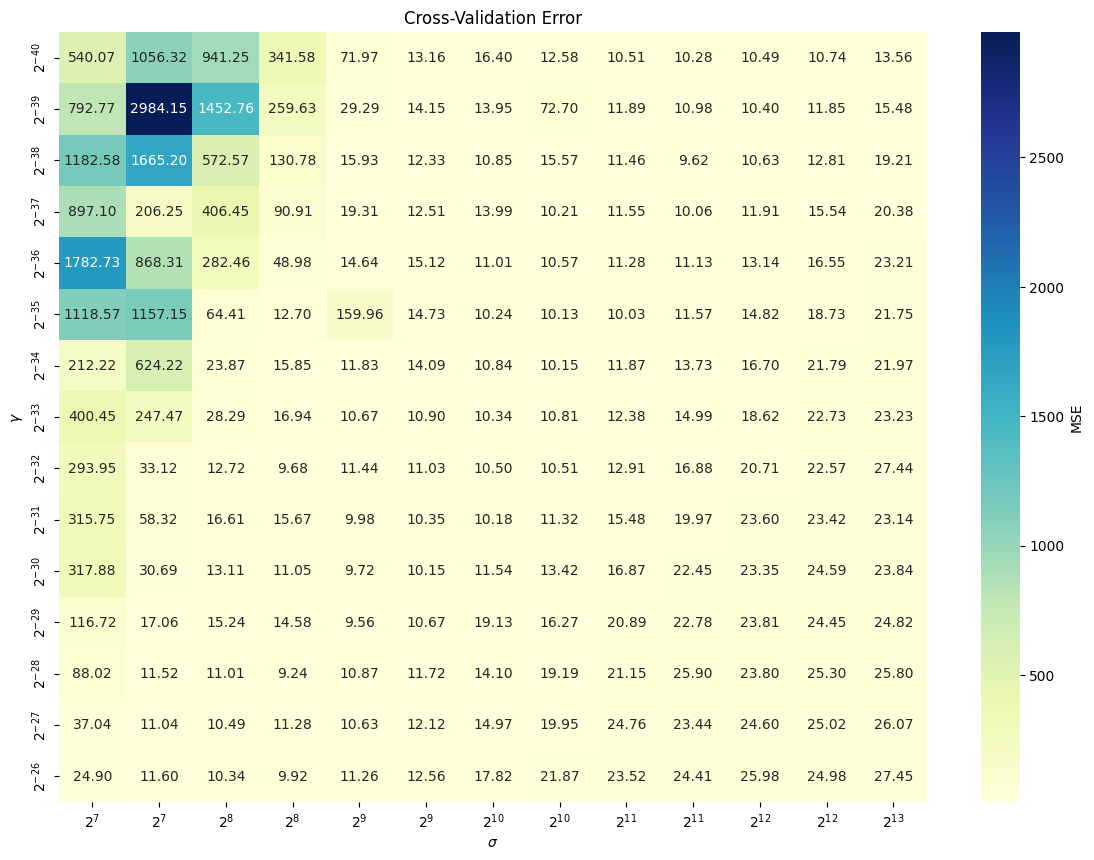

In [18]:
""" 1.3 Q5(b) """
# Convert the parameters to power of two representation
gamma_labels = [to_power_of_two(g) for g in gamma]
sigma_labels = [to_power_of_two(s) for s in sigma]

plt.figure(figsize=(14, 10))
sns.heatmap(mean_square_errors, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=sigma_labels, yticklabels=gamma_labels, cbar_kws={'label': 'MSE'})
plt.xlabel('$\sigma$')
plt.ylabel('$\gamma$')
plt.title('Cross-Validation Error')
plt.savefig("q5_b.png", dpi=400)
plt.show()

In [19]:
""" 1.3 Q5(c) """
X_train_val, y_train_val = X_train.values, y_train.values
X_test_val, y_test_val = X_test.values, y_test.values

K = compute_kernel(X_train_val, best_sigma)
alpha = np.linalg.inv(K + best_gamma * len(K) * np.identity(len(K))) @ y_train_val

y_train_preds = [sum(alpha[i] * gaussian_kernel(X_train_val[i], x_train, best_sigma) for i in range(len(X_train_val))) for x_train in X_train_val]
y_test_preds = [sum(alpha[i] * gaussian_kernel(X_train_val[i], x_test, best_sigma) for i in range(len(X_train_val))) for x_test in X_test_val]
print(f"Best Parameters Training MSE: {calculate_mse(y_train, y_train_preds):.3f}")
print(f"Best Parameters Test MSE: {calculate_mse(y_test, y_test_preds):.3f}")

Best Parameters Training MSE: 5.442
Best Parameters Test MSE: 19.266


In [20]:
""" 1.3 Q5(d) """
mses_naive = np.zeros([20, 2])
mses_single_attribute = np.zeros([20, 12, 2])
mses_all_attribute = np.zeros([20, 2])
mses_krr = np.zeros([20, 2])

# Run all regression over 20 random splits of data
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    naive_regression(X_train, X_test, y_train, y_test, mses_naive, i)
    single_attribute_regression(X_train, X_test, y_train, y_test, mses_single_attribute, i)
    all_attribute_regression(X_train, X_test, y_train, y_test, mses_all_attribute, i)
    kernel_ridge_regression(X_train, X_test, y_train, y_test, mses_krr, i)
    
show_mean_and_std(mses_naive, mses_single_attribute, mses_all_attribute, mses_krr)

---------------- Naive Regression ----------------
Training Error --- 83.597 ± 4.437
Test Error     --- 86.332 ± 8.954

------------- Linear Regression (attribute 1) -------------
Training Error --- 71.053 ± 4.355
Test Error     --- 73.855 ± 8.814

------------- Linear Regression (attribute 2) -------------
Training Error --- 72.478 ± 4.013
Test Error     --- 75.814 ± 8.227

------------- Linear Regression (attribute 3) -------------
Training Error --- 63.613 ± 4.810
Test Error     --- 67.198 ± 9.890

------------- Linear Regression (attribute 4) -------------
Training Error --- 81.261 ± 4.007
Test Error     --- 83.723 ± 8.327

------------- Linear Regression (attribute 5) -------------
Training Error --- 68.299 ± 4.685
Test Error     --- 70.707 ± 9.552

------------- Linear Regression (attribute 6) -------------
Training Error --- 42.379 ± 3.753
Test Error     --- 46.514 ± 7.912

------------- Linear Regression (attribute 7) -------------
Training Error --- 71.613 ± 4.663
Test Error  